# Unsupervised Learning: DB-Scan Clustering

In the previous notebook, you learned about K-Means clustering, which is a centroid-based clustering algorithm. In this notebook, you will learn about `DBSCAN` clustering, which is a density-based clustering algorithm. 

The `DBSCAN` algorithm is based on the idea that a cluster is a dense area surrounded by a sparse area. The algorithm works by defining clusters as continuous regions of high density. Here are the main concepts of the `DBSCAN` algorithm:

- **Core Points**: A point is a core point if it has at least a minimum number of other points ($minPts$) within a distance $\epsilon$.
- **Directly Reachable**: A point $P$ is directly reachable from another point $Q$ if $P$ is within $\epsilon$ distance from $Q$ and $Q$ is a core point.
- **Reachable Points**: A point is a reachable point if it is reachable from a core point and has fewer than $minPts$ within $\epsilon$.
- **Noise Points**: All other points that are neither core points nor reachable points are noise points.
- **Reachability**: A point $Q$ is reachable from another point P if there is a path of points $P_1, P_2, \ldots , P_n$, with $P_1 = P$ and $P_n = Q$, such that each Pi+1 is directly reachable from Pi.


The `DBSCAN` algorithm works as follows:

1. Randomly select a point P.
2. Retrieve all points directly reachable from P.
3. If P is a core point, a cluster is formed.
4. If P is a reachable point, no more points (than the core point) are reachable from P, and `DBSCAN` moves to the next point.
5. Repeat the process until all points have been processed.

For a graphical representation of the `DBSCAN` algorithm see the course slides. For more information see the [DBSCAN Wikipedia page](https://en.wikipedia.org/wiki/DBSCAN).

In this notebook, you will apply the DBSCAN algorithm to the shop customer dataset we saw in the previous notebook. Luckily, `sklearn` makes it easy to apply the `DBSCAN` algorithm. Let's get started!


In [ ]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.environ['DATA_DIRECTORY'] = '/content'
else:
    os.environ['DATA_DIRECTORY'] = '../../data'

data_directory = os.getenv('DATA_DIRECTORY')

In [ ]:
%%bash
if [ ! -f "$DATA_DIRECTORY/course-data.zip" ]; then
    wget "https://gitlab.com/api/v4/projects/52375047/jobs/artifacts/master/raw/data/course-data.zip?job=build_data_zip" -O "$DATA_DIRECTORY/course-data.zip"
    unzip "$DATA_DIRECTORY/course-data.zip" -d "$DATA_DIRECTORY"
fi

In [ ]:
import pandas as pd

customers_df = pd.read_csv(os.path.join(data_directory, 'customers-dataset/Customers.csv'))
customers_df.head()

CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  
0     Healthcare                1            4  
1       Engineer                3            3  
2       Engineer                1            1  
3         Lawyer                0            2  
4  Entertainment                2            6

## Preprocessing

Before doing any clustering, you need to preprocess the data. We perform the same preprocessing steps as in the previous notebook. First, we drop the `CustomerID` column:

In [4]:
customers_df.drop(columns=['CustomerID'], inplace=True)

Then we impute the missing values in the `Profession` column:

In [5]:
customers_df["Profession"].fillna('mode', inplace=True)

Next, we encode the categorical columns using the `LabelEncoder` class from `sklearn`:

In [6]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["Gender", "Profession"]

for categorical_column in categorical_columns:
    encoder = LabelEncoder()
    customers_df[categorical_column] = encoder.fit_transform(customers_df[categorical_column])

customers_df.head()

Gender  Age  Annual Income ($)  Spending Score (1-100)  Profession  \
0       1   19              15000                      39           5   
1       1   21              35000                      81           2   
2       0   20              86000                       6           2   
3       0   23              59000                      77           7   
4       0   31              38000                      40           3   

   Work Experience  Family Size  
0                1            4  
1                3            3  
2                1            1  
3                0            2  
4                2            6

Finally, we scale the data using the `StandardScaler` class from `sklearn`:

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

customers_df[customers_df.columns] = scaler.fit_transform(customers_df)
customers_df.head()

Gender       Age  Annual Income ($)  Spending Score (1-100)  Profession  \
0  1.207064 -1.054089          -2.093501               -0.428339    0.778356   
1  1.207064 -0.983723          -1.656133                1.075546   -0.354347   
2 -0.828457 -1.018906          -0.540845               -1.609962   -0.354347   
3 -0.828457 -0.913356          -1.131292                0.932319    1.533491   
4 -0.828457 -0.631891          -1.590528               -0.392532    0.023220   

   Work Experience  Family Size  
0        -0.791207     0.117497  
1        -0.281162    -0.390051  
2        -0.791207    -1.405148  
3        -1.046230    -0.897599  
4        -0.536185     1.132594

## Clustering

Now that you have preprocessed the data, you can apply the `DBSCAN` algorithm to the data. For more information, see the documentation on the  [sklearn DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) class.

In [1]:
#begin solution

In [8]:
#TODO can we optimize this further?
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(customers_df)

customers_df['Cluster'] = dbscan.labels_

### Evaluating the DBSCAN algorithm

In [9]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

dbscan_evaluation = pd.DataFrame({
    'silhouette_score': silhouette_score(customers_df, dbscan.labels_),
    'calinski_harabasz_score': calinski_harabasz_score(customers_df, dbscan.labels_)
}, index=[0])

dbscan_evaluation

silhouette_score  calinski_harabasz_score
0         -0.072401                 9.015241

### Visualizing the clusters

Let's visualize the clusters created by the `DBSCAN` algorithm. Again, we will use a `PCA` to reduce the dimensionality of the data to two dimensions. We will then plot the clusters in the `PCA` dimensions.

<Axes: >

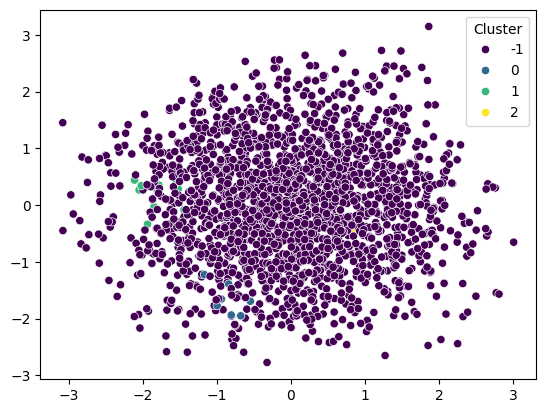

In [10]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
customers_df_pca = pca.fit_transform(customers_df[customers_df.columns[:-1]])

sns.scatterplot(x=customers_df_pca[:, 0], y=customers_df_pca[:, 1], hue=customers_df["Cluster"], palette='viridis')

To make the clusters more apparent, we filter out the noise points. We then plot the clusters in different colors.

<Axes: >

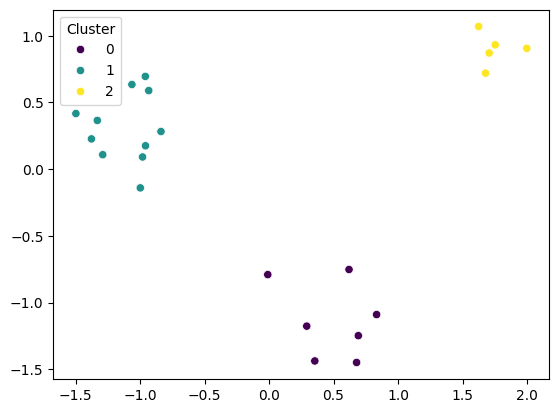

In [11]:
customers_clusters_df = customers_df[customers_df['Cluster'] != -1]

pca = PCA(n_components=2)
customers_clusters_pca = pca.fit_transform(customers_clusters_df[customers_clusters_df.columns[:-1]])

sns.scatterplot(x=customers_clusters_pca[:, 0], y=customers_clusters_pca[:, 1], hue=customers_clusters_df["Cluster"], palette='viridis')

As we can see, the `DBSCAN` algorithm also does not perform well on this dataset. We see it has created three clusters, but the clusters are not very clear. In addition, a large majority of the points are classified as noise points.

In [2]:
#end solution


# Conclusion

In this notebook, you learned about the `DBSCAN` clustering algorithm. You applied the `DBSCAN` algorithm to the shop customer dataset and visualized the dataset. You've learned that it is difficult to compare the performance of the `DBSCAN` algorithm with the `K-Means` algorithm because `DBSCAN` works very differently. The `DBSCAN` algorithm is a density-based clustering algorithm that is useful when the clusters are not spherical or when the clusters have different densities. Measures like the `silhouette score` and the `calinsk-harabasz` are not that useful for evaluating the performance of the `DBSCAN` algorithm, as these scores are based on the distance between the points and the centroids and therefore prefer spherical clusters. When comparing the `DBSCAN` algorithm with the `K-Means` algorithm, these measures would almost always favor the `K-means` algorithm (more information [here](https://www.reddit.com/r/datascience/comments/yzir4v/comment/ix81sb0/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button) and [here](https://github.com/christopherjenness/DBCV)). 

In this lies the difficulty of evaluating the performance of cluster algorithms. As we often do not have a ground-truth value, as was the case with supervised learning, the evaluation of cluster algorithms is often subjective. The best way to evaluate the performance of a clustering algorithm is to use domain knowledge and visualize the clusters. 